In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


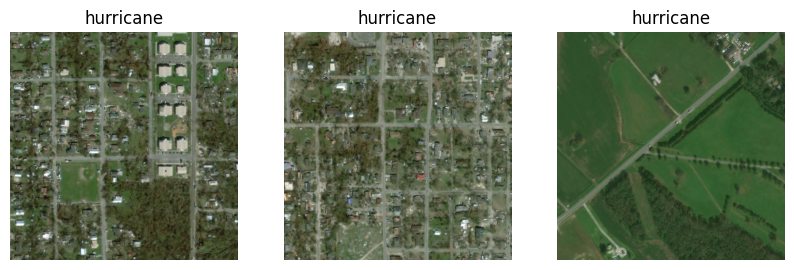

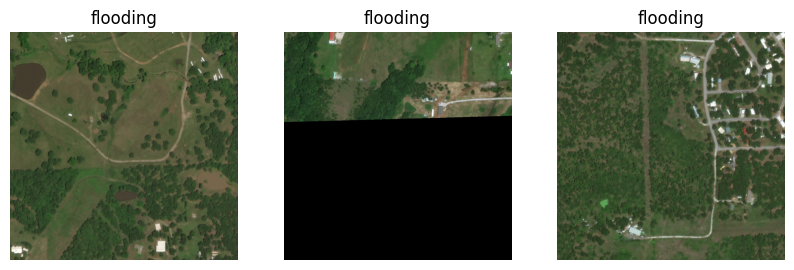

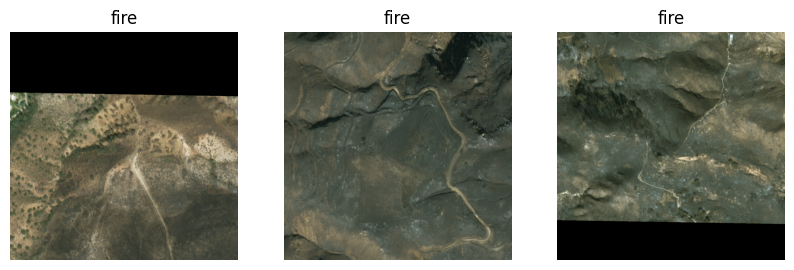

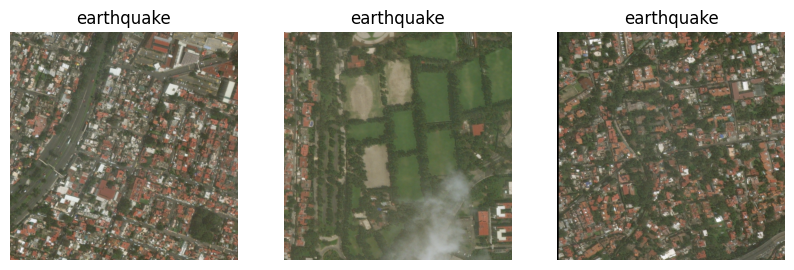

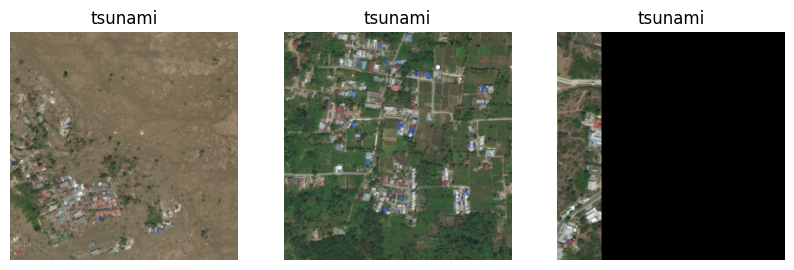

In [ ]:
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

zip_path = '/content/drive/MyDrive/ADS Project/update/small_data.zip'

# Disaster types categories
disaster_types = ["hurricane", "fire", "wind", "flooding", "tsunami", "earthquake"]

disaster_images = {}

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    filenames = z.namelist()
    # Process each file
    for filename in filenames:
        if 'post_disaster' in filename and filename.lower().endswith(valid_extensions):
            # Determine disaster type by checking keywords in filename
            found_type = None
            for dtype in disaster_types:
                if dtype in filename.lower():
                    found_type = dtype
                    break

            if found_type:
                with z.open(filename) as file:
                    img = Image.open(file)
                    img.load()  # Load the image data

                if found_type not in disaster_images:
                    disaster_images[found_type] = [img]
                elif len(disaster_images[found_type]) < 3:
                    disaster_images[found_type].append(img)

# Plot sample images for each disaster type
for disaster_type, images in disaster_images.items():
    plt.figure(figsize=(10, 3))
    for i, img in enumerate(images, start=1):
        plt.subplot(1, len(images), i)
        plt.imshow(img)
        plt.title(disaster_type)
        plt.axis('off')
    plt.show()

Distribution of Disaster Types:
hurricane: 1219
flooding: 279
fire: 1049
earthquake: 121
tsunami: 113


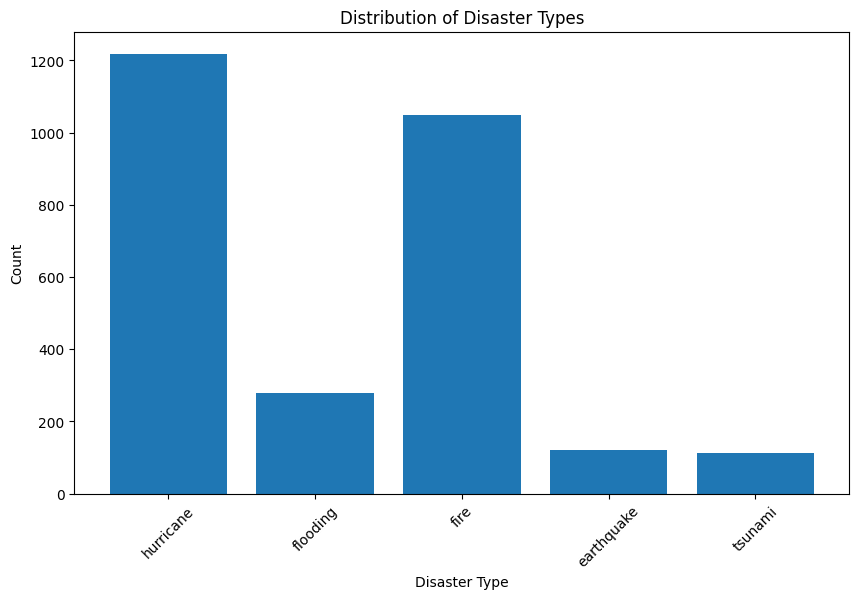

In [ ]:
import zipfile
from collections import Counter

zip_path = '/content/drive/MyDrive/ADS Project/update/small_data.zip'

disaster_types = ["hurricane", "fire", "wind", "flooding", "tsunami", "earthquake"]

# Counter to store the counts of each disaster type
disaster_distribution = Counter()

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    filenames = z.namelist()
    # Process each file
    for filename in filenames:
        if 'post_disaster' in filename:
            found_type = None
            for dtype in disaster_types:
                if dtype in filename.lower():
                    found_type = dtype
                    break

            if found_type:  # If a disaster type is found
                disaster_distribution[found_type] += 1

# Print the distribution of disaster types
print("Distribution of Disaster Types:")
for disaster, count in disaster_distribution.items():
    print(f"{disaster}: {count}")

# Plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(disaster_distribution.keys(), disaster_distribution.values())
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Distribution of Disaster Types')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import zipfile
from PIL import Image
from io import BytesIO

zip_path = '/content/drive/MyDrive/ADS Project/update/small_data.zip'

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    filenames = z.namelist()
    for filename in filenames:
        if 'post_disaster' in filename and filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                with z.open(filename) as file:
                    img = Image.open(BytesIO(file.read()))
                    img.verify()  # Verify that it is, indeed, an image
            except (IOError, SyntaxError) as e:
                print(f"Corrupted file detected: {filename}")

In [ ]:
image_stats = {'dimensions': [], 'modes': []}

with zipfile.ZipFile(zip_path, 'r') as z:
    filenames = z.namelist()
    for filename in filenames:
        if 'post_disaster' in filename and filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                with z.open(filename) as file:
                    img = Image.open(BytesIO(file.read()))
                    image_stats['dimensions'].append(img.size)
                    image_stats['modes'].append(img.mode)
            except Exception as e:
                continue  # Skip corrupted files

# Print average dimensions and mode statistics
from collections import Counter
dimension_counts = Counter(image_stats['dimensions'])
mode_counts = Counter(image_stats['modes'])
print("Most common dimensions:", dimension_counts.most_common(1))
print("Most common color modes:", mode_counts.most_common())

Most common dimensions: [((1024, 1024), 2799)]
Most common color modes: [('RGB', 2799)]


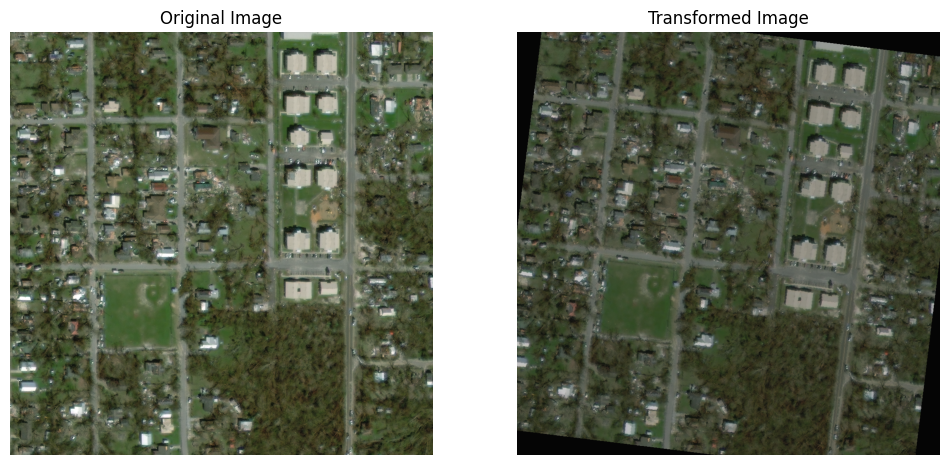

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from io import BytesIO

zip_path = '/content/drive/MyDrive/ADS Project/update/small_data.zip'

# Simple augmentation with random transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

with zipfile.ZipFile(zip_path, 'r') as z:
    image_files = [f for f in z.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        # Open first image
        with z.open(image_files[0]) as file:
            img = Image.open(BytesIO(file.read()))

            # Apply the transformation and plot both original and transformed images
            img_transformed = transform(img)

            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            plt.title('Original Image')
            plt.imshow(img)
            plt.axis('off')

            plt.subplot(122)
            plt.title('Transformed Image')
            plt.imshow(img_transformed)
            plt.axis('off')

            plt.show()
    else:
        print("No image files found in the ZIP archive.")

In [ ]:
import os
import zipfile
from PIL import Image
from io import BytesIO
import cv2
import numpy as np
from torchvision import transforms

zip_path = '/content/drive/MyDrive/ADS Project/update/small_data.zip'

# Output directory
base_output_dir = '/content/drive/MyDrive/ADS Project/update/processed_images'

disaster_types = ["hurricane", "fire", "wind", "flooding", "tsunami", "earthquake"]

# Ensure the base directory exists
os.makedirs(base_output_dir, exist_ok=True)

# Define the image transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Function to process images
def process_and_save_image(file, filename, disaster_type):
    # Create directory for the disaster type if it doesn't exist
    disaster_output_dir = os.path.join(base_output_dir, disaster_type)
    os.makedirs(disaster_output_dir, exist_ok=True)

    # Read image in PIL format
    img = Image.open(BytesIO(file.read()))

    # Convert PIL image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Denoise image
    img_denoised = cv2.fastNlMeansDenoisingColored(img_cv, None, 10, 10, 7, 21)

    # Convert back to PIL image
    img_pil = Image.fromarray(cv2.cvtColor(img_denoised, cv2.COLOR_BGR2RGB))

    # Resize image
    img_resized = img_pil.resize((256, 256), Image.ANTIALIAS)

    # Apply transformations
    img_transformed = transform(img_resized)

    # Save the processed image
    img_transformed.save(os.path.join(disaster_output_dir, filename))

# Open the ZIP file and process each image
with zipfile.ZipFile(zip_path, 'r') as z:
    image_files = [f for f in z.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in image_files:
        disaster_type = None
        for dtype in disaster_types:
            if dtype in img_file.lower():  # Check if the disaster type is in the filename
                disaster_type = dtype
                break
        if disaster_type:
            with z.open(img_file) as file:
                process_and_save_image(file, os.path.basename(img_file), disaster_type)

print("Processing complete. Images organized by disaster type in:", base_output_dir)

<ipython-input-46-9bf53543ef5a>:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img_pil.resize((256, 256), Image.ANTIALIAS)


Processing complete. Images organized by disaster type in: /content/drive/MyDrive/ADS Project/update/processed_images
